## Are pre-trained and custom GPT-2 models aware of island constraints?

Tokenizing sentences and calculating token-by-token surprisal uses helper functions of `minicons` package (https://github.com/kanishkamisra/minicons). For fine-tuning, I referred to the [tutorial](https://github.com/philschmid/fine-tune-GPT-2/blob/master/Fine_tune_a_non_English_GPT_2_Model_with_Huggingface.ipynb) "Finetune a non-English GPT-2 Model with Huggingface."

### Load required packages

In [ ]:
!pip install transformers==4.10.0 torch==1.8.1 sentencepiece==0.1.96 minicons

In [3]:
from minicons import scorer
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from transformers import pipeline,AutoTokenizer,TextDataset,DataCollatorForLanguageModeling,Trainer,TrainingArguments,AutoModelWithLMHead
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import json
from scipy import stats

In [4]:
#access files saved in Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### GPT-2 pre-trained model
I am using a Japanese GPT-2 model trained by [Colorful Scoop](https://colorfulscoop.com/).

In [ ]:
pretrained_model = scorer.IncrementalLMScorer("colorfulscoop/gpt2-small-ja", 'cpu')

In [ ]:
def batch_surprisal_transformer(model, data):
  dataset = pd.DataFrame(columns = ["island", "sent_number", "token", "surprisal"]) 
  sent_number = 0
  for i, row in data.iterrows():
    tokens = []
    surprisals = []
    sent_number += 1
    results = model.token_score(row['sentence'], surprisal = True, base_two = True)
    for i in results:
      for j in i:
        tokens.append(j[0])
        surprisals.append(j[1])
    if row['island'] == 1:
      to_append = {'island': list(np.repeat(1, len(tokens), axis=0)),
                   'sent_number': list(np.repeat(sent_number, len(tokens), axis=0)),
                   'token': tokens,
                   'surprisal': surprisals}
      dataset = dataset.append(pd.DataFrame(to_append))
    elif row['island'] == 0:
      to_append = {'island': list(np.repeat(0, len(tokens), axis=0)),
                   'sent_number': list(np.repeat(sent_number, len(tokens), axis=0)),
                   'token': tokens,
                   'surprisal': surprisals}
      dataset = dataset.append(pd.DataFrame(to_append))
  return dataset

Import test data, and compute token-by-token surprisal using the LM

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Classes/LIGN 167 - FA22/test_stimuli_new.csv')

In [ ]:
#get and save the result
result = batch_surprisal_transformer(pretrained_model, data)
result.to_csv('/content/drive/MyDrive/Classes/LIGN 167 - FA22/result_GPT2_pretrained.csv')

After exporting the result, I manually coded the region of interest (i.e., all the words following the noun that underwent long-distance relativization), and reimported the edited version.

In [ ]:
result_edited = pd.read_csv('/content/drive/MyDrive/Classes/LIGN 167 - FA22/result_GPT2_pretrained.csv')

In [ ]:
#get mean surprisal on the critical region by group (island=1/non-island=0)
critical = result_edited[result_edited['critical']==1]
critical.groupby('island')['surprisal'].mean()

island
0    7.525918
1    9.004205
Name: surprisal, dtype: float64

In [ ]:
stats.ttest_rel(critical[critical['island']==0]['surprisal'], critical[critical['island']==1]['surprisal'])

Ttest_relResult(statistic=-4.147493468097395, pvalue=0.00013625515527677056)

The results suggest that GPT-2 trained entirely on Japanese dataset assigns higher surprisals to words that have undergone long-distance extraction out of an island, compared with words that have just undergone long-distance extraction (no island violation). In other words, it is possible that GPT-2 has learned the relative clause island constraint.

### GPT-2 model finetuned with additional data
Thanks to the fact that the tokenizer associated with the Japanese GPT-2 model is available, we can finetune this model using additional data  

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("colorfulscoop/gpt2-small-ja")

Downloading:   0%|          | 0.00/328 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/803k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129 [00:00<?, ?B/s]

In [ ]:
%cd '/content/drive/MyDrive/Classes/LIGN 167 - FA22/'

/content/drive/MyDrive/Classes/LIGN 167 - FA22


In [ ]:
ft_data = pd.read_csv('finetuning_stimuli.csv')

#split between train and valid data, convert it to txt
ft_data_val = ft_data.sample(n = 14)
with open('finetuning_stimuli_val_gpt.txt', 'w') as f:
  for sent in ft_data_val['sentence'].tolist():
    f.write(' '.join(sent))
    f.write('\n')

ft_data_train = ft_data.drop(ft_data.index[ft_data_val.index.tolist()])
with open('finetuning_stimuli_train_gpt.txt', 'w') as f:
  for sent in ft_data_train['sentence'].tolist():
    f.write(' '.join(sent))
    f.write('\n')

In [ ]:
train_path = '/content/drive/MyDrive/Classes/LIGN 167 - FA22/finetuning_stimuli_train_gpt.txt'
test_path = '/content/drive/MyDrive/Classes/LIGN 167 - FA22/finetuning_stimuli_val_gpt.txt'

In [ ]:
def load_dataset(train_path,test_path,tokenizer):
    train_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=train_path,
          block_size=128)
     
    test_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=test_path,
          block_size=128)   
    
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False,
    )
    return train_dataset,test_dataset,data_collator

train_dataset,test_dataset,data_collator = load_dataset(train_path,test_path,tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/data/datasets/language_modeling.py:58: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,


In [ ]:
model = AutoModelWithLMHead.from_pretrained("colorfulscoop/gpt2-small-ja")

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Classes/LIGN 167 - FA22/gpt2-jpajt", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=300, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=64,  # batch size for evaluation
    eval_steps = 400, # Number of update steps between two evaluations.
    save_steps=800, # after # steps model is saved 
    warmup_steps=500,# number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    )


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 51
  Num Epochs = 300
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 600


Step,Training Loss
500,0.816700




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=600, training_loss=0.6853594926993052, metrics={'train_runtime': 493.9872, 'train_samples_per_second': 30.972, 'train_steps_per_second': 1.215, 'total_flos': 999442022400000.0, 'train_loss': 0.6853594926993052, 'epoch': 300.0})

In [ ]:
trainer.save_model()

Saving model checkpoint to /content/drive/MyDrive/Classes/LIGN 167 - FA22/gpt2-jpajt
Configuration saved in /content/drive/MyDrive/Classes/LIGN 167 - FA22/gpt2-jpajt/config.json
Model weights saved in /content/drive/MyDrive/Classes/LIGN 167 - FA22/gpt2-jpajt/pytorch_model.bin


In [ ]:
custom_model = scorer.IncrementalLMScorer("mahotaka/gpt2-ja-custom", 'cpu')

In [ ]:
#get and save the result
result = batch_surprisal_transformer(custom_model, data)
result.to_csv('/content/drive/MyDrive/Classes/LIGN 167 - FA22/result_GPT2_custom.csv')

In [5]:
result_edited = pd.read_csv('/content/drive/MyDrive/Classes/LIGN 167 - FA22/result_GPT2_custom.csv')

In [6]:
#get mean surprisal on the critical region by group (island/non-island)
critical = result_edited[result_edited['critical']==1]
critical.groupby('island')['surprisal'].mean()

island
0    7.821412
1    9.870345
Name: surprisal, dtype: float64

In [7]:
stats.ttest_rel(critical[critical['island']==0]['surprisal'], critical[critical['island']==1]['surprisal'])

Ttest_relResult(statistic=-5.344821098765744, pvalue=2.4680163705434485e-06)

### Visualize results

In [ ]:
pretrained = pd.read_csv('/content/drive/MyDrive/Classes/LIGN 167 - FA22/result_GPT2_pretrained.csv')
custom = pd.read_csv('/content/drive/MyDrive/Classes/LIGN 167 - FA22/result_GPT2_custom.csv')

In [ ]:
def add_token_num(df):
  token_number = []
  for i in df['sent_number'].unique():
    token_number.extend(range(1,len(df[df['sent_number'] == i])+1))
  df['token_number'] = token_number
  return df

In [ ]:
pretrained = add_token_num(pretrained)
custom = add_token_num(custom)

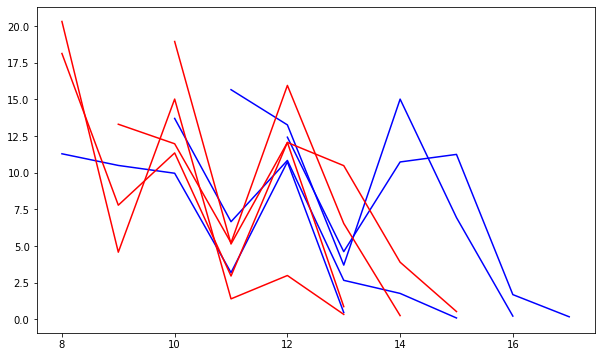

In [ ]:
figure(figsize = (10, 6))

for i in range(1,5):
  subset = pretrained[(pretrained['sent_number']==i)&(pretrained['critical']==1)]
  plt.plot(subset['token_number'], subset['surprisal'], color='blue')

for i in range(9,13):
  subset = pretrained[(pretrained['sent_number']==i)&(pretrained['critical']==1)]
  plt.plot(subset['token_number'], subset['surprisal'], color='red')

plt.show()

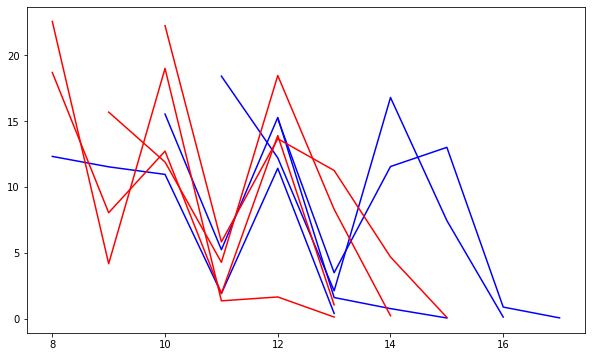

In [ ]:
figure(figsize = (10, 6))

for i in range(1,5):
  subset = custom[(custom['sent_number']==i)&(custom['critical']==1)]
  plt.plot(subset['token_number'], subset['surprisal'], color='blue')

for i in range(9,13):
  subset = custom[(custom['sent_number']==i)&(custom['critical']==1)]
  plt.plot(subset['token_number'], subset['surprisal'], color='red')

plt.show()